In [179]:
import shutil
from zipfile import ZipFile as zf
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer 

In [180]:
# unrar
SEED = 101

with zf('Clinic.zip','r') as zin:
    zin.extractall()
    shutil.rmtree('25yjwbphn4-1')

In [181]:
# load data
df = pd.read_csv('Dataset.csv',encoding='utf-8')
medications = pd.read_csv('Medicationkey.csv')

df.rename(columns={'ID': 'Patient'}, inplace=True)
df.set_index('Patient',inplace=True)
medications.set_index('Medication', inplace=True)

# As-is, drug names have been shortened to alphabet letters, let's revert that
old_columns = medications.values.flatten()
new_columns = medications.index

for old, new in zip(old_columns, new_columns):
    df.rename(columns={old: new}, inplace=True)

In [182]:
# Get a sense of what features we are dealing with in this set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD', 'Assignment',
       'EMR', 'LOS', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE',
       'BUPROPION', 'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE',
       'CLONIDINE', 'DOXEPIN', 'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE',
       'FLUPHENAZINE', 'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL',
       'IMIPRAMINE', 'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE',
       'NORTRIPTYLINE', 'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE',
       'ZIPRASIDONE', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

In [183]:
# Clean unconventional column names
df.rename(columns={'# Administrations': 'Administrations'}, inplace=True)
df.rename(columns={'# Psychotropic Medications': 'Psychotropics'}, inplace=True)
df.rename(columns={'RACE/ETHNICITY': 'Ethnicity'}, inplace=True)

In [184]:
print('Checking for void values:')
df[df.columns[df.isnull().any()]].isnull().sum()

Checking for void values:


Assignment               41
Therapeutic Guidances    41
dtype: int64

In [185]:
'''
My strategy: 
Fill NaN with the most frequent value for each category
Note: mode() is the same as doing df[c].value_counts().index[0]
'''
# df["Assignment"].fillna(df["Assignment"].mode().iloc[0], inplace=True)
# df["Therapeutic Guidances"].fillna(df["Therapeutic Guidances"].mode().iloc[0], inplace=True)

# Simpler way to do this: 
df = pd.DataFrame(
    SimpleImputer(strategy='most_frequent',missing_values=np.nan).fit_transform(df)
    ,columns=df.columns)
# TODO convert categories to num so .corr() can detect them

In [186]:
# We have a problem here: Multiple values for one column
pd.DataFrame(df['Diagnosis'].unique())

,0
0,"MDD, Recurrent, Unspecified"
1,"MDD, Single Episode, Severe With Psychotic Fea..."
2,Depressive Disorder NOS
3,"MDD, Single Episode,Severe Without Psychotic F..."
4,"MDD, Single Episode, Unspecified"
5,"MDD, Recurrent, Severe With Psychotic Features"
6,"MDD, Recurrent, Severe Without Psychotic Features"
7,"MDD, Recurrent, Moderate"
8,Mood Disorder NOS
9,Schizoaffective Disorder


c:\Users\W\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
c:\Users\W\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


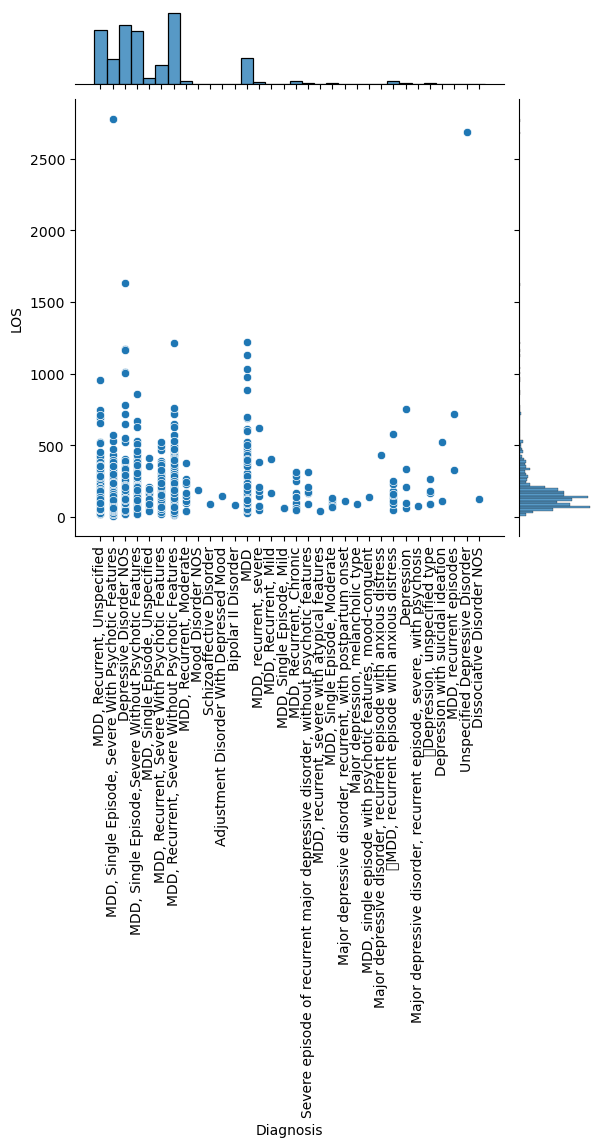

In [187]:
# Should we drop it?
sns.jointplot(data=df,x='Diagnosis',y='LOS')
plt.xticks(rotation=90);

In [190]:
from sklearn.preprocessing import OrdinalEncoder

df['Diagnosis'] = OrdinalEncoder().fit_transform(df['Diagnosis'].to_numpy().reshape(-1,1))
df['Diagnosis'] = df['Diagnosis'].astype(int)
# TODO why int converts to object?
df['LOS'] = df['LOS'].astype(int)
df['RAR'] = df['RAR'].astype(bool)
corr_rar = np.around(df['RAR'].corr(df['Diagnosis']),4)
corr_los = np.around(df['LOS'].corr(df['Diagnosis']),4)
print(f'RAR and Diagnosis are {corr_rar}% corr while LOS and Diagnosis are {corr_los}% correlated')

# Drop Diagnosis as it is not important to predict LOS
df.drop('Diagnosis',axis=1,inplace=True)

RAR and Diagnosis are 0.0186% corr while LOS and Diagnosis are -0.0041% correlated


In [155]:
df.groupby(['RAR']).count().transpose().head(1)

RAR,False,True
GENDER,1358,142


########################
Discharged people : 1358 Recurrent people: 142 with a 9.56 imbalance
########################


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


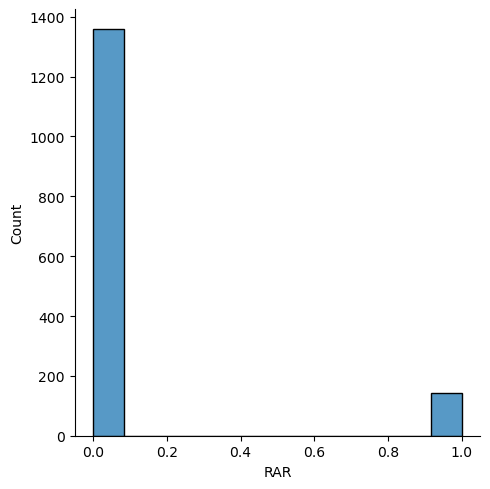

In [156]:
# Understanding data

discharged_ppl,recurrent_ppl = df['RAR'].value_counts()
imbalance_ratio = np.around(discharged_ppl / recurrent_ppl,2)
print('########################')
print(f'Discharged people : {discharged_ppl} Recurrent people: {recurrent_ppl} with a {imbalance_ratio} imbalance')
print('########################')
sns.displot(df['RAR'])

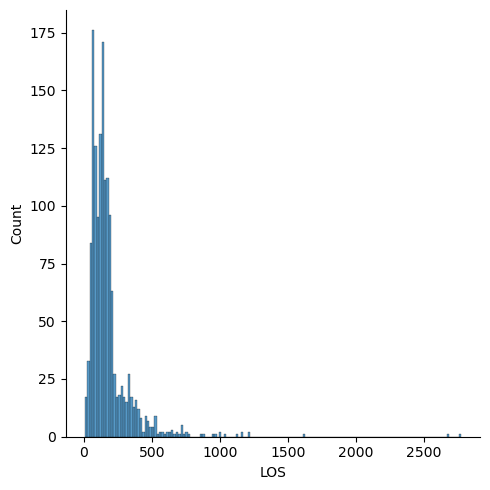

count    1500.000000
mean      176.520667
std       174.259930
min         6.000000
25%        90.000000
50%       138.000000
75%       191.250000
max      2776.000000
Name: LOS, dtype: float64


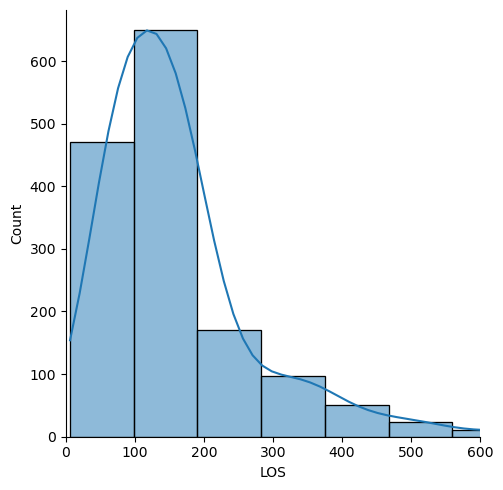

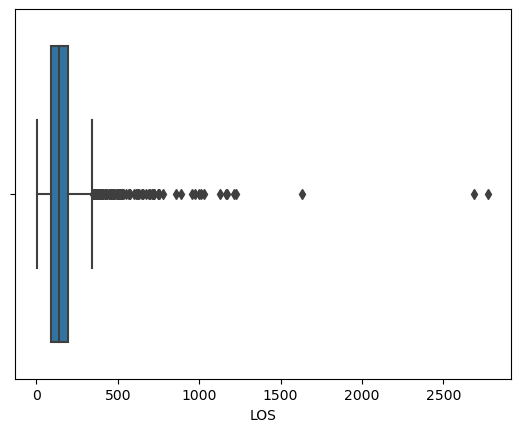

In [157]:
# Since RAR is heavely imbalanced, let's try to focus on another outcome: The Length of Stay (LOS)

sns.displot(df['LOS'])
plt.show()
# Most patients don't stay more than 200 days
print(df['LOS'].describe())
sns.displot(data=df,x='LOS',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='LOS')
plt.show()

In [158]:
# Considering ... I have opted for dropping outliers above a year of LOS (365d)
YEAR = 365
n_leftover_patients = df[df['LOS']<=YEAR].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100

# Drop the columns
df.drop(df[df['LOS'] > YEAR].index,inplace=True)

print("Percentage of patients retained: {:.2f}%".format(percentage))
print(f"Now set has {df.shape[0]} patients")

Percentage of patients retained: 92.07%
Now set has 1381 patients


<Axes: xlabel='Ethnicity', ylabel='LOS'>

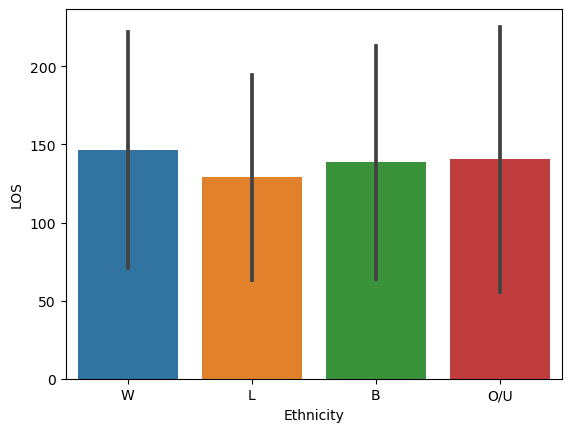

In [159]:
# White patients tend to vary most and have on avg the majority of LOS
sns.barplot(data=df, x='Ethnicity', y='LOS', estimator=np.mean, errorbar='sd')

<Axes: xlabel='LOS', ylabel='Administrations'>

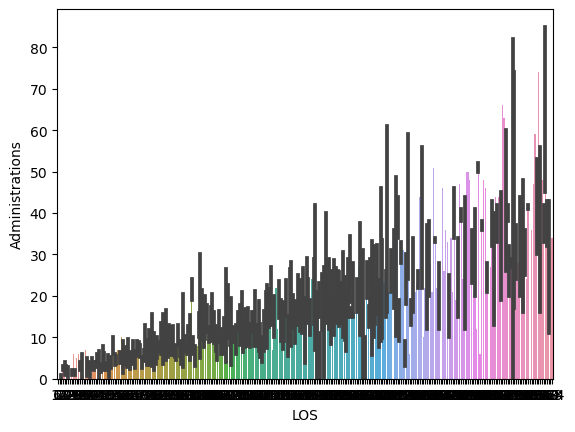

In [160]:
# Here we cannot see the number of people who fall into these ranges but rather only how total drug intake + days in clinic are  correlated
sns.barplot(data=df,x='LOS',y='Administrations')

In [167]:
df

,GENDER,AGE,Ethnicity,MD,Assignment,EMR,LOS,RAR,AMITRIPTYLINE,ARIPIPRAZOLE,...,PERPHENAZINE,QUETIAPINE,RISPERIDONE,SERTRALINE,TRAZODONE,VENLAFAXINE,ZIPRASIDONE,Psychotropics,Administrations,Therapeutic Guidances
0,F,49,W,L,G,C,70,False,2,0,...,0,0,0,0,1,0,0,3,6,EG
1,F,21,W,A,G,C,309,False,0,0,...,0,13,0,0,0,0,0,3,27,CT
3,F,63,L,L,G,C,115,False,0,0,...,0,0,5,0,0,0,0,3,14,CT
4,M,34,L,G,S,C,120,False,0,0,...,0,5,0,0,0,0,0,3,11,EG
5,F,24,L,T,S,C,120,False,0,5,...,0,0,0,0,5,0,0,4,13,EG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,F,41,B,G,G,C,68,False,0,0,...,0,0,6,0,0,0,0,1,6,EG
1496,F,51,L,A,G,C,62,False,0,0,...,0,0,0,0,0,0,0,2,5,CT
1497,F,62,W,F,G,C,114,False,0,0,...,0,19,0,0,2,0,0,3,26,EG
1498,F,23,W,D,G,C,210,False,0,0,...,0,0,0,0,2,0,0,1,2,CT


C:\Users\W\AppData\Local\Temp\ipykernel_11300\393060756.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index


<Axes: >

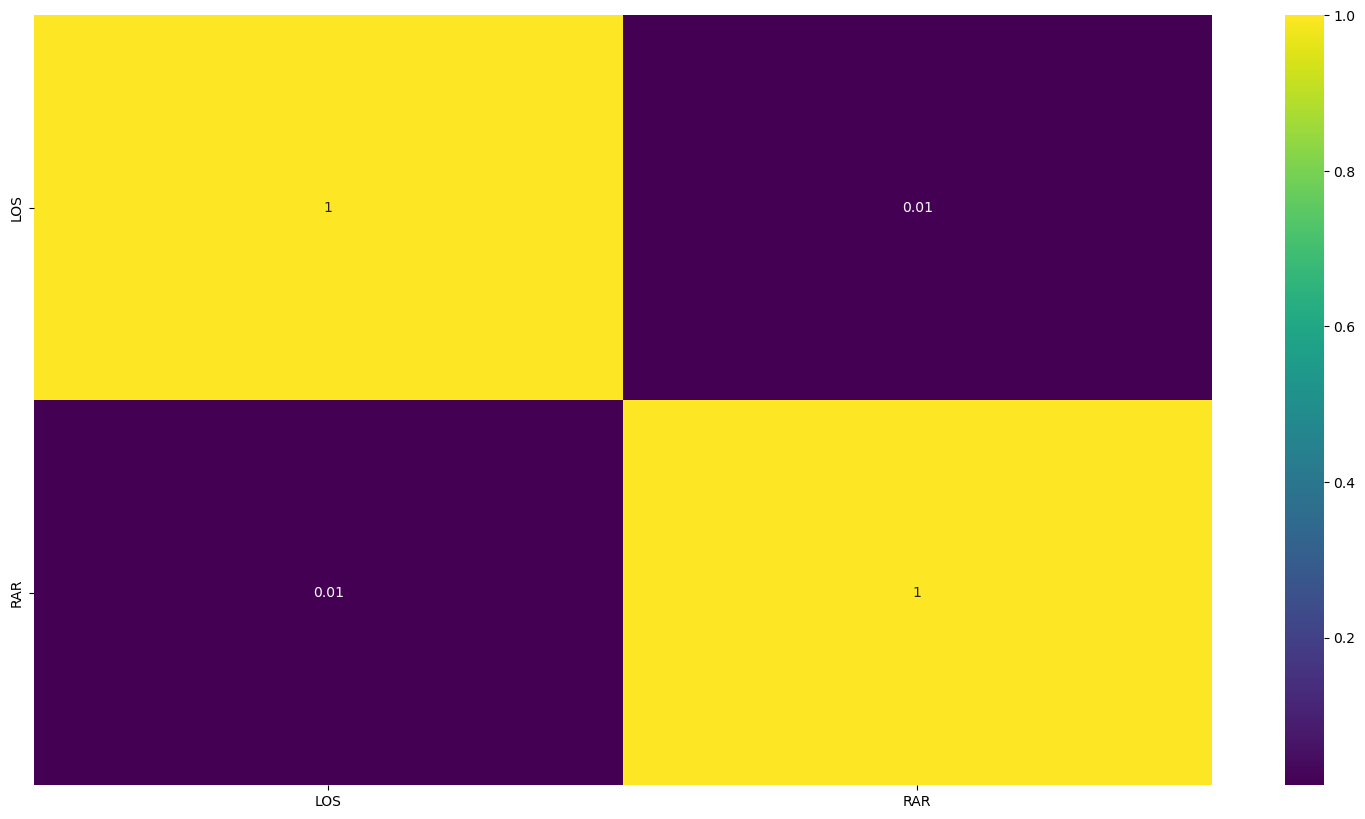

In [165]:
# There seems to be a correlation between the length of stay (LOS) and the amount of medications patients had to take
# Let's corroborate that presumption by plotting a heatmap!

plt.figure(figsize=(19,10),dpi=100)
cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [162]:
# Too many features, isn't it? 

def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=True))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

clean_useless_cols(df,'LOS')

#########################
starting with 41 cols
#########################
RAR    0.010312
LOS    1.000000
Name: LOS, dtype: float64

#########################
irrelevant cols found (constants):
#########################
Series([], dtype: float64)

#########################
voila! set cleared. 41 cols left to work with
#########################


C:\Users\W\AppData\Local\Temp\ipykernel_11300\691254445.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr().nlargest(df.columns.size, y_label)
C:\Users\W\AppData\Local\Temp\ipykernel_11300\691254445.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()


# WIP

In [ ]:
# Let's get our hands dirty
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE,RFECV
from sklearn.model_selection import train_test_split

clf = DecisionTreeClassifier(random_state=101)
OG_X = df.drop('LOS', axis=1)
# ????
alternative_x_vraag = OG_X.select_dtypes('number')

DummyX = pd.get_dummies(OG_X,drop_first=True)
y = df['LOS']

# Error encountered! 
# The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
# X_train, X_test, y_train, y_test = train_test_split(
#     OG_X, y, random_state=101, shuffle=1, test_size=0.3, stratify=y)

# TODO Solution: Combine values so you don't end up with single datapoints for very similar ranges

In [ ]:
# test...

from sklearn.linear_model import ElasticNetCV

DummyX.columns
# TODO continue cleaning OR feed to ensemble / nn

Index(['AGE', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE', 'BUPROPION',
       'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE', 'CLONIDINE', 'DOXEPIN',
       'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE', 'FLUPHENAZINE',
       'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL', 'IMIPRAMINE',
       'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE', 'NORTRIPTYLINE',
       'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE', 'QUETIAPINE',
       'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE', 'ZIPRASIDONE',
       'Psychotropics', 'Administrations', 'GENDER_M', 'Ethnicity_L',
       'Ethnicity_O/U', 'Ethnicity_W',
       'Diagnosis_\tMDD, recurrent episode with anxious distress',
       'Diagnosis_Adjustment Disorder With Depressed Mood',
       'Diagnosis_Bipolar II Disorder', 'Diagnosis_Depression',
       'Diagnosis_Depression with suicidal ideation',
       'Diagnosis_Depressive Disorder NOS',
       'Diagnosis_Dissociative Disorder NOS', 'Diagnosis_MDD',
       'Diagnosis_MDD, 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
# TODO Error Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']
# XX = LabelEncoder().fit_transform(OG_X.to_numpy().reshape(-1,1))

In [ ]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

def acc_confusion(clf,X,y):
    print('#########################')
    print(f'accuracy: {accuracy_score(y,clf.predict(X))}')
    print('#########################')
    ConfusionMatrixDisplay.from_estimator(clf,X,y)

In [ ]:
clf = DecisionTreeClassifier().fit(alternative_x_vraag,y)

# Vanilla
clf.score(alternative_x_vraag,y)

0.9594496741491673

In [ ]:
# Possible feature selection
# KBest
skb = SelectKBest(chi2, k=5).fit(X_train, y_train)
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
# Recurrent Feature Extraction with Cross-Validation
rfecv = RFECV(clf,step=1,scoring='accuracy',cv=5).fit(X_train,y_train)

SKBX_train = skb.transform(X_train)
SKBX_test = skb.transform(X_test)
pd.DataFrame({'ft': OG_X.columns, 'score': skb.scores_}
             ).sort_values('score', ascending=0)
print(f'SKB OG ft: {X_train.shape[1:]} | best ft: {SKBX_train.shape[1:]}')

RFEX_train = rfe.transform(X_train)
RFEX_test = rfe.transform(X_test)
rfe_df = pd.DataFrame({'ft':OG_X.columns,'ranking':rfe.ranking_}).sort_values('ranking')
keep_ft = rfe_df.loc[rfe_df['ranking']<2,'ranking'].count()
print(f'RFE now considering {keep_ft} cols')

RFECVX_train = rfecv.transform(X_train)
RFECVX_test = rfecv.transform(X_test)
print(f'RFECV says {X_train.columns[rfecv.support_]} ({rfecv.n_features_}) as best ft\'s to keep')

NameError: name 'X_train' is not defined

In [ ]:
'''ERRORS encountered on the way'''
